# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

Using TensorFlow backend.


# Load Data

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255
x_test = x_test / 255

In [3]:
M,N,L = 32,32,3
IM_SHAPE = (M,N,L)
ENCODE_LEN = 64

In [4]:
IM_DIR = os.getcwd() + '/natural_images/dog/'
filetype = '.jpg'
files = os.listdir(IM_DIR)
NUM_IMS = 700
assert(len(files) > NUM_IMS)
images = np.zeros((NUM_IMS, ) + IM_SHAPE)
i = 0
for filename in files:
    if filename[-4:] == '.jpg':
        im = plt.imread(IM_DIR + filename)
        if len(im.shape) == 3:
            im = cv2.resize(im, IM_SHAPE[:2])
            im = im / 255
            images[i] = im
            i += 1
            if i >= NUM_IMS:
                break
images = np.array(images)
images.shape

(700, 32, 32, 3)

# Make Model

In [247]:
inputs = keras.Input(shape=IM_SHAPE)
inputsB = keras.Input(shape=IM_SHAPE)

grads = layers.Conv2D(filters=16,
                      kernel_size=2,
                      strides=2,
                      activation='tanh')(inputs)

grads = layers.Conv2D(filters=32,
                      kernel_size=4,
                      strides=1,
                      activation='tanh')(grads)

grads = layers.Conv2D(filters=64,
                      kernel_size=4,
                      strides=1,
                      activation='tanh')(grads)
grads = layers.MaxPool2D(pool_size=(2, 2))(grads)

encoding = layers.Conv2D(filters=128,
                      kernel_size=4,
                      strides=1,
                      activation='tanh')(grads)

encoding = layers.Flatten()(encoding)

encoder = keras.Model(inputs=inputs, outputs=encoding)
encoder.summary()

decode_input = keras.Input(shape=mix.shape[1:])
decode = layers.Dense(2, activation='softmax')(decode_input)

decoder = keras.Model(inputs=decode_input, outputs=decode)
decoder.summary()

mix = layers.Concatenate()([encoder(inputs), encoder(inputsB)])

classifier= keras.Model(inputs=[inputs, inputsB], outputs=decoder(mix))
opt = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
classifier.compile(optimizer=opt, loss='categorical_crossentropy')
classifier.summary()

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 16, 16, 16)        208       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 13, 13, 32)        8224      
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 10, 10, 64)        32832     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 2, 2, 128)         131200    
_________________________________________________________________
flatten_22 (Flatten)         (None, 512)               0  

# Train

W0421 17:32:24.332328  1304 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


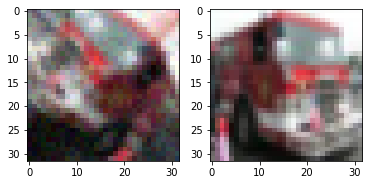

In [248]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=45,
    horizontal_flip=1,
    vertical_flip=1,
    channel_shift_range=0.1,
    shear_range=15,
)
datagen.fit(x_train)

for x, y in datagen.flow(x_test, x_test):
    x = x + (30/255)*np.random.rand(*x.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(x[0])
    plt.subplot(1, 2, 2)
    plt.imshow(y[0])
    break

Exception ignored in: <function ScopedTFGraph.__del__ at 0x0000020C8C5BA8B8>
Traceback (most recent call last):
  File "c:\users\royce schultz\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\c_api_util.py", line 52, in __del__
    c_api.TF_DeleteGraph(self.graph)
KeyboardInterrupt


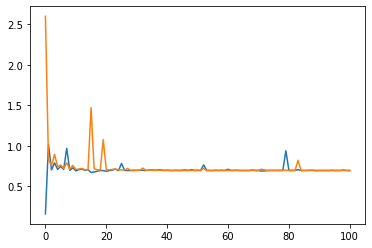

In [249]:
i = 0
match_loss = []
mismatch_loss = []
nitts = 100
for x,y in datagen.flow(x_train, x_train, batch_size=128):
    
#     x = x + (30/255)*np.random.rand(*x.shape)
#     x = y + (30/255)*np.random.rand(*x.shape)
    
    match_ans = np.zeros((len(x),2))
    match_ans[:,0] = 1
    mismatch_ans = np.zeros((len(x)-1,2))
    mismatch_ans[:,1] = 1
    
    match_history = classifier.fit([x, y], match_ans, epochs=1, verbose=0).history
    mismatch_history = classifier.fit([y[1:], y[:-1]],mismatch_ans, epochs=1, verbose=0).history
    match_loss.append(match_history['loss'][0])
    mismatch_loss.append(mismatch_history['loss'][0])
    
    classifier.fit([y, x], match_ans, epochs=1, verbose=0)
    classifier.fit([x[1:], x[:-1]],mismatch_ans, epochs=1, verbose=0)
    
#     classifier.fit([y, y],match_ans, epochs=1, verbose=0)
#     classifier.fit([x[2:], x[:-2]],mismatch_ans[1:], epochs=1, verbose=0)

    print(f'{100*i / nitts:.1f}% ( {match_loss[-1]:.3f} , {mismatch_loss[-1]:.3f} )', end='\r')
    
    i += 1
    if i > nitts:
        break
plt.plot(match_loss)
plt.plot(mismatch_loss)

In [223]:
def similarity(im1, im2, plot=True):
    sim = classifier.predict([np.array([im1]), np.array([im2])])[0,0]
    if plot:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(im1)
        plt.subplot(1,2,2)
        plt.imshow(im2)
        plt.title(sim)
    return sim

def Esim(im1, im2):
    vec = np.array([np.concatenate([im1, im2])])
    return decoder.predict(vec)[0,0]

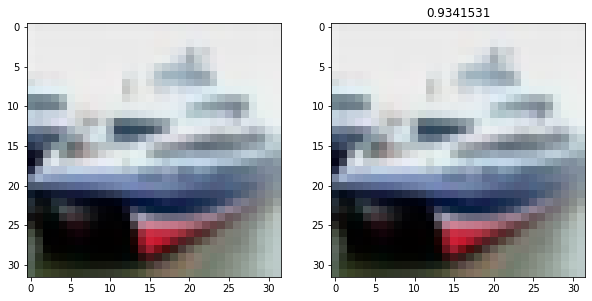

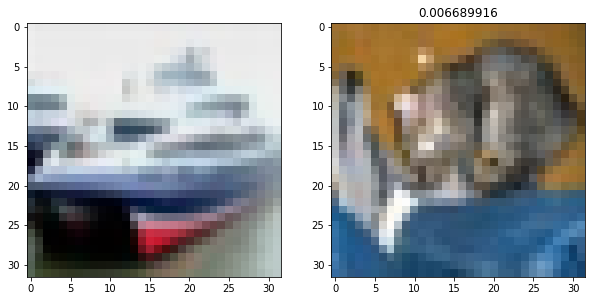

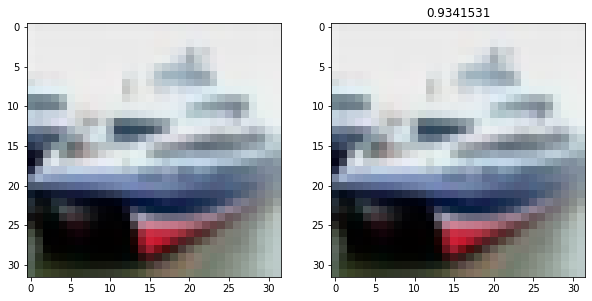

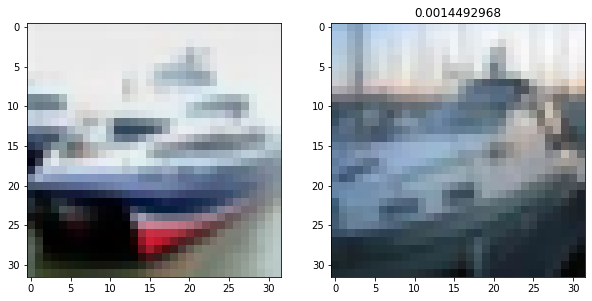

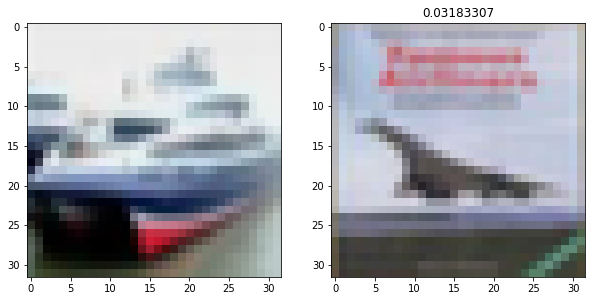

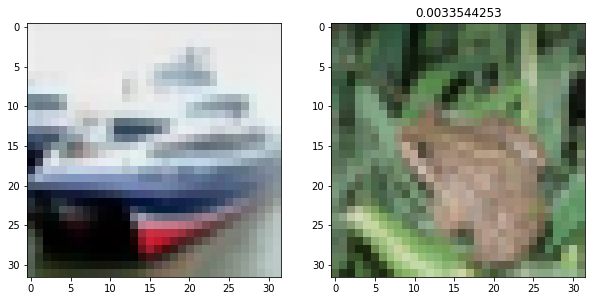

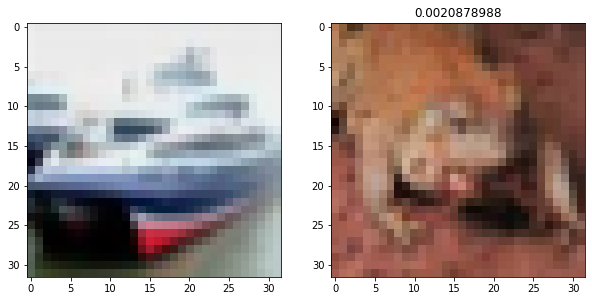

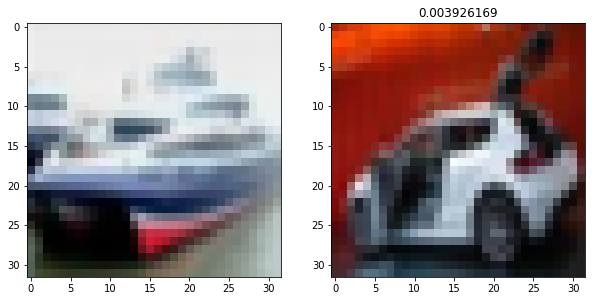

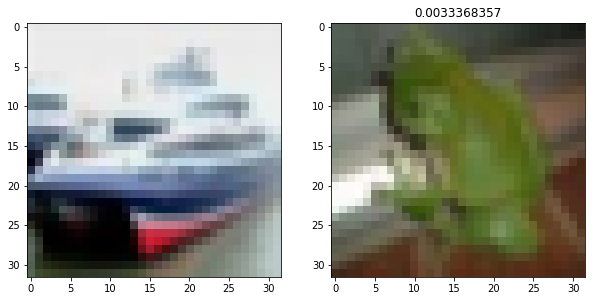

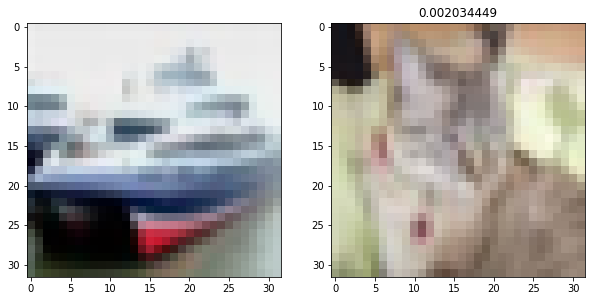

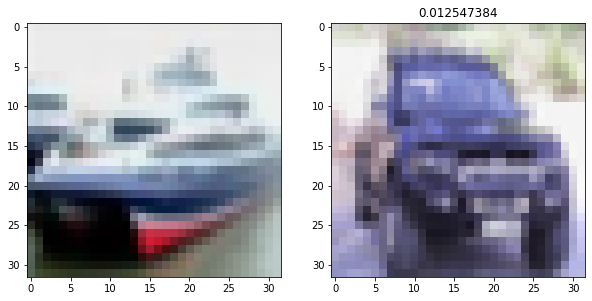

In [239]:
j = np.random.randint(1000)
j = 1
similarity(x_test[j], x_test[j])
for i in range(10):
    similarity(x_test[j], x_test[i])

In [246]:
encodings = encoder.predict(x_test)
n = len(x_test)
n = 500
affinity = np.zeros((n,n))
for i in range(n):
    print(f'{100*i/n:.3f}%', end='\r')
    for j in range(i,n):
        affinity[i,j] = Esim(encodings[i],encodings[j])
        affinity[j,i] = affinity[i,j]

KeyboardInterrupt: 

In [ ]:
plt.imshow(affinity)

In [ ]:
aProp = AffinityPropagation(affinity='precomputed')
aff_clusters = aProp.fit_predict(affinity)

In [ ]:
aff_clusters

In [ ]:
adjusted_rand_score(y_test[:n].reshape((-1,)), aff_clusters)

In [ ]:
row += 1
print(row)
ranks = np.argsort(affinity[row,:])[::-1]
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[ranks[i]])
    plt.title(f'{ranks[i]}: {affinity[row,ranks[i]]:.3f}')
plt.tight_layout()

In [2]:
def testClusters(clusters):
    return adjusted_rand_score(y_test.reshape((-1,)), clusters)

def testEncodings(encodings):
    print('calculating k means...')
    k_clusters = KMeans(10).fit_predict(encodings)
    print('calculating agglomerative clustering...')
    a_clusters = AgglomerativeClustering(10).fit_predict(encodings)
    print(f'K Means Score: {testClusters(k_clusters)}')
    print(f'Agglomerative Score: {testClusters(a_clusters)}')

In [6]:
cluster = np.random.randint(10, size=(len(y_test)))
testClusters(cluster)

1.624800309694636e-06

In [ ]:
encodings = encoder.predict(x_test)

In [ ]:
testEncodings(encodings)

In [ ]:
testEncodings(x_shrink)

In [ ]:
testEncodings(np.random.rand(len(x_shrink),1))

In [87]:
def testAccuracy(acc):
    n = 20000
    true_labels = np.random.randint(10, size=(n,))
    pred_labels = np.zeros(n)
    for i in range(n):
        if np.random.rand() >= acc:
            pred_labels[i] = np.random.randint(10)
#             while pred_labels[i] == true_labels[i]:
#                 pred_labels[i] = np.random.randint(10)
        else:
            pred_labels[i] = true_labels[i]
            
    return adjusted_rand_score(true_labels, pred_labels)


In [88]:
testAccuracy(.80)

0.6371649814010412

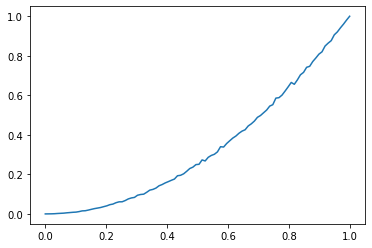

In [89]:
xs = np.linspace(0,1,100)
ys = np.zeros(100)
for i,x in enumerate(xs):
    ys[i] = testAccuracy(x)
plt.plot(xs,ys)

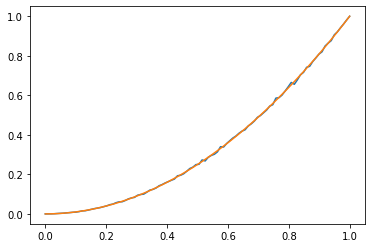

In [93]:
plt.plot(xs,ys)
plt.plot(xs, xs**2)

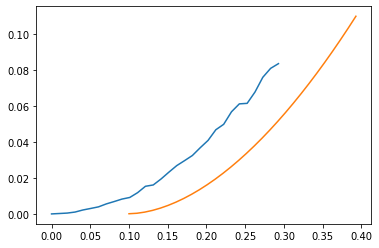

In [91]:
start=0
end=30
plt.plot(xs[start:end],ys[start:end])
plt.plot(xs[start:end]+.1,xs[start:end]**1.8)